# Blackjack with RL framework

Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

**Actions**: Agents can pick between two actions:
 - Stick (0): the player takes no more cards
 - Hit (1): the player will be given another card, however the player could get over 21 and bust



##  Environment 




In [ ]:
%matplotlib inline
!pip install gymnasium==1.0.0
!wget https://raw.githubusercontent.com/laktionov/RL-course/refs/heads/2025/hw2/agent_utils.py
!wget https://raw.githubusercontent.com/laktionov/RL-course/refs/heads/2025/hw2/visualisation_utils.py

In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym

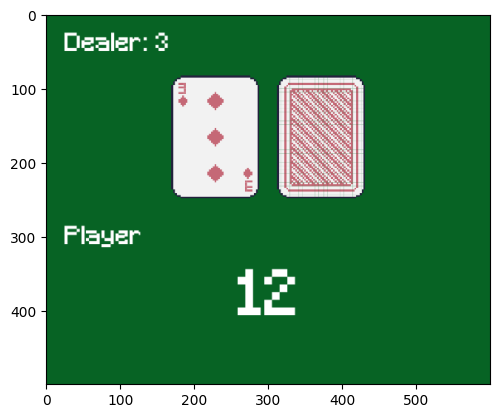

In [3]:
env = gym.make("Blackjack-v1", sab=True, render_mode="rgb_array")
state, _ = env.reset()
plt.imshow(env.render())

## train Q-learning agent 

In [4]:
from typing import TypeAlias
StateType: TypeAlias = tuple[int, int, bool]

class Agent:
    def __init__(
        self,
        n_actions: int,
        learning_rate: float,
        epsilon: float,
        discount_factor: float = 0.95,
    ):
        self.n_actions = n_actions
        self.q_values = defaultdict(lambda: np.zeros(n_actions))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = epsilon

        self.mse = []

    def on_episode_start(self):
        pass

    def get_best_action(self, state: StateType):
        return np.argmax(self.q_values[state])

    def get_action(self, state: StateType) -> int:
        if np.random.random() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            return self.get_best_action(state)


class QLearningAgent(Agent):
    def get_value(self, state: StateType):
        return max(self.q_values[state])

    def update(
        self,
        state: StateType,
        action: int,
        reward: float,
        terminated: bool,
        next_state: StateType,
    ):
        next_q_value = (1 - terminated) * self.get_value(next_state)
        td_error = reward + self.discount_factor * next_q_value - self.q_values[state][action]

        self.q_values[state][action] = self.q_values[state][action]  + self.lr * td_error
        self.mse.append(td_error**2)

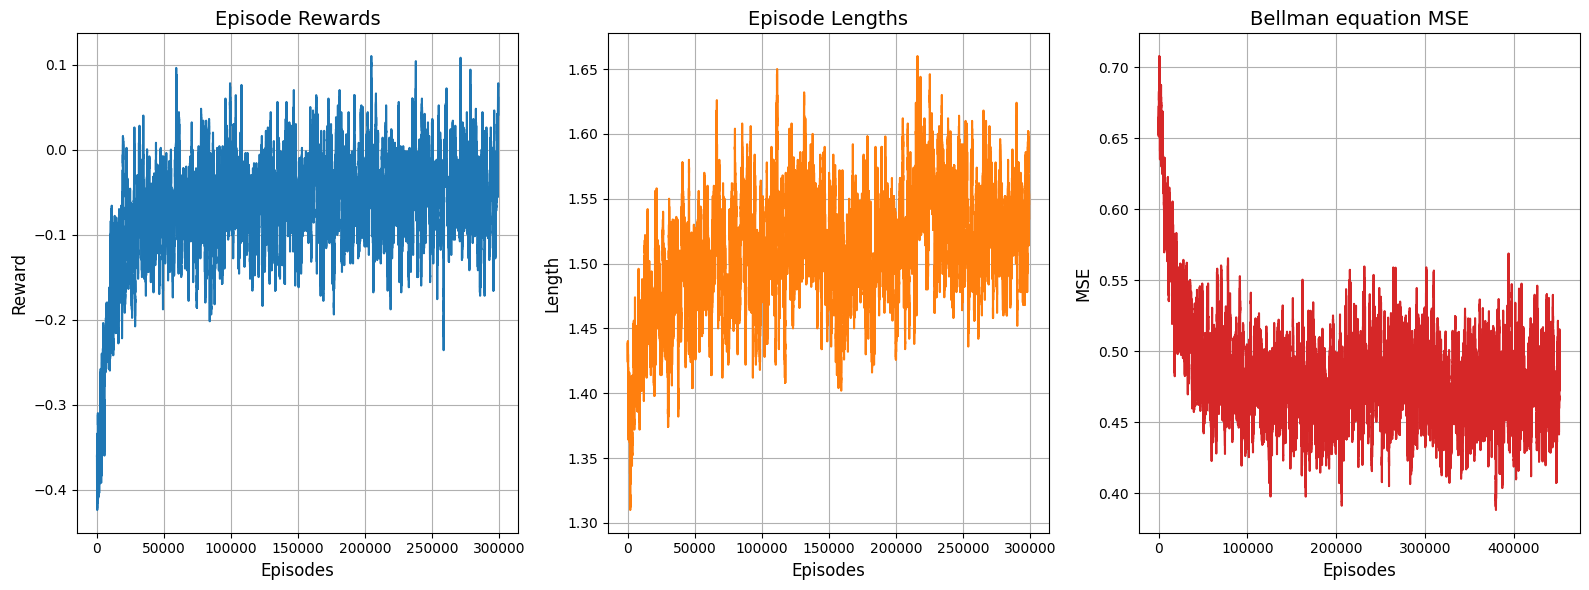

100%|██████████| 300000/300000 [01:28<00:00, 3372.52it/s]


<RecordEpisodeStatistics<OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>>

In [5]:
from agent_utils import train_agent

n_episodes = 300_000
learning_rate = 4e-3
n_actions = env.action_space.n
epsilon = 1.0

env = gym.make("Blackjack-v1", sab=True)
q_learning_agent = QLearningAgent(
    n_actions=env.action_space.n,
    learning_rate=learning_rate,
    epsilon=epsilon,
)
train_agent(q_learning_agent, env, n_episodes, epsilon_decay=0.9)

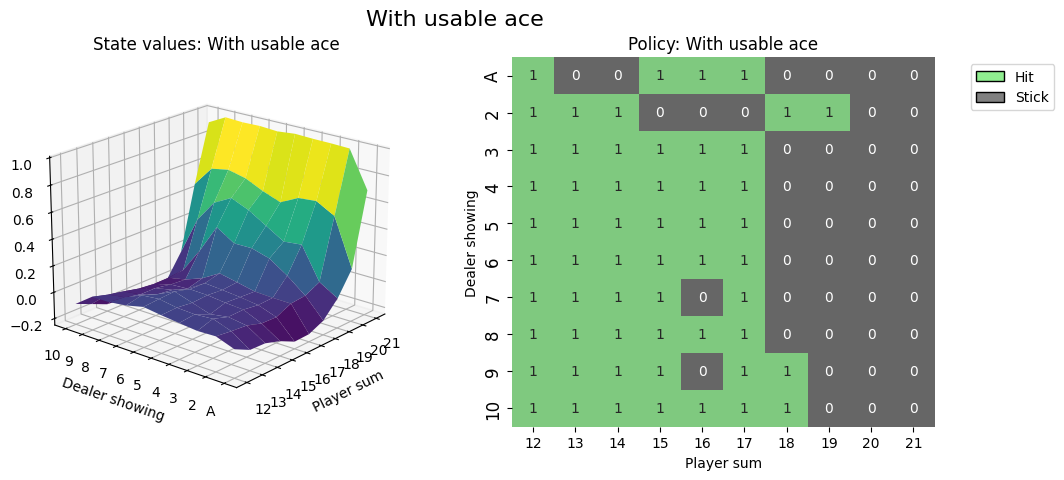

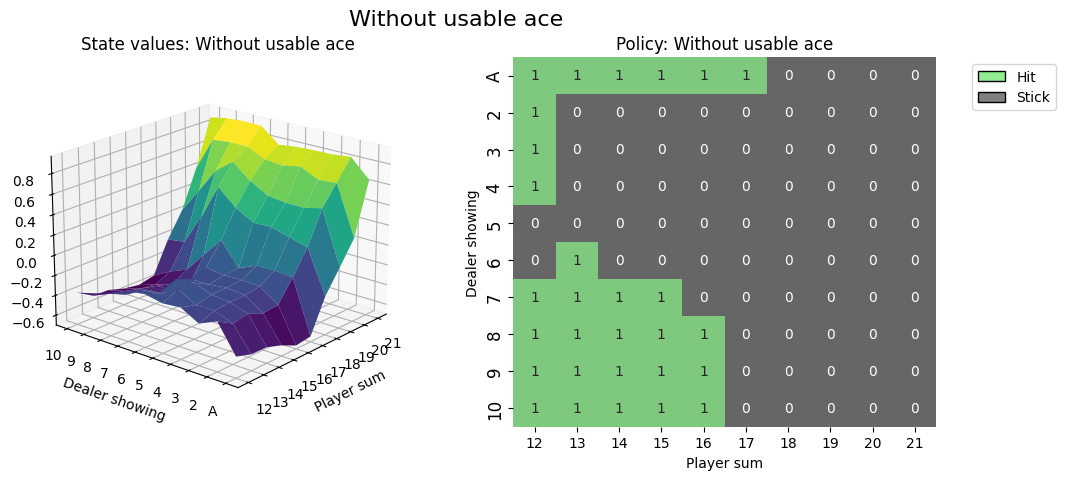

In [6]:
from visualisation_utils import visualise_strategy
visualise_strategy(q_learning_agent)

##  Implementation of Sarsa($\lambda$)

###  Eligibility Traces

Eligibility traces are a mechanism to bridge between TD(0) methods and Monte-Carlo methods. They "trace" the states (and actions) visited recently, decaying over time, allowing updates to propagate backwards quickly.

### 1.2. Sarsa($\lambda$)

Sarsa($\lambda$) is an **on-policy** method that uses eligibility traces $e(s, a)$

Initialise $Q(s, a)$

Initialise $e(s, a)$ with zeros on each episode start

1. Sample $a_t \sim \mu(.|s_t)$, where $\mu(.|s_t)$ is $\epsilon$-greedy policy w.r.t. current approximation of $Q$.
2. Observe $r_t$ and $s_{t+1}$
3. Calculate $ \delta_t = r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t),$
4. $ e(s_t, a_t) \leftarrow e(s_t, a_t) + 1 $
5. For **all** state-action pairs $(s, a)$:
   * $Q(s,a) \leftarrow Q(s,a) + \alpha \delta_t \cdot e(s,a)$

   * $e(s,a) \leftarrow \gamma \lambda \cdot e(s,a)$

Sarsa($\lambda$) uses the **action taken** by the current policy (often $\epsilon$-greedy w.r.t. $Q$) for the bootstrap term.

In [7]:
class SarsaAgent(Agent):
    def __init__(
        self,
        n_actions: int,
        learning_rate: float,
        epsilon: float,
        decay_factor: float,
        discount_factor: float = 0.95,
    ):
        super().__init__(n_actions, learning_rate, epsilon, discount_factor)
        self.decay_factor = decay_factor
        self.on_episode_start()

    def on_episode_start(self):
        self.e_traces = defaultdict(lambda: np.zeros(self.n_actions))

    def get_value(self, state: StateType):
        action = self.get_action(state)
        value = self.q_values[state][action]
        return value

    def update(
        self,
        state: StateType,
        action: int,
        reward: float,
        terminated: bool,
        next_state: StateType,
    ):
        next_q_value = (1 - terminated) * self.get_value(next_state)
        td_error = reward + self.discount_factor * next_q_value - self.q_values[state][action]
        self.e_traces[state][action] = self.e_traces[state][action] + 1
        for s in self.q_values:
            for a in range(self.n_actions):
                self.q_values[s][a] = self.q_values[s][a] + self.lr * td_error * self.e_traces[s][a]
                self.e_traces[s][a] = self.e_traces[s][a]  * self.discount_factor * self.decay_factor
        self.mse.append(td_error**2)

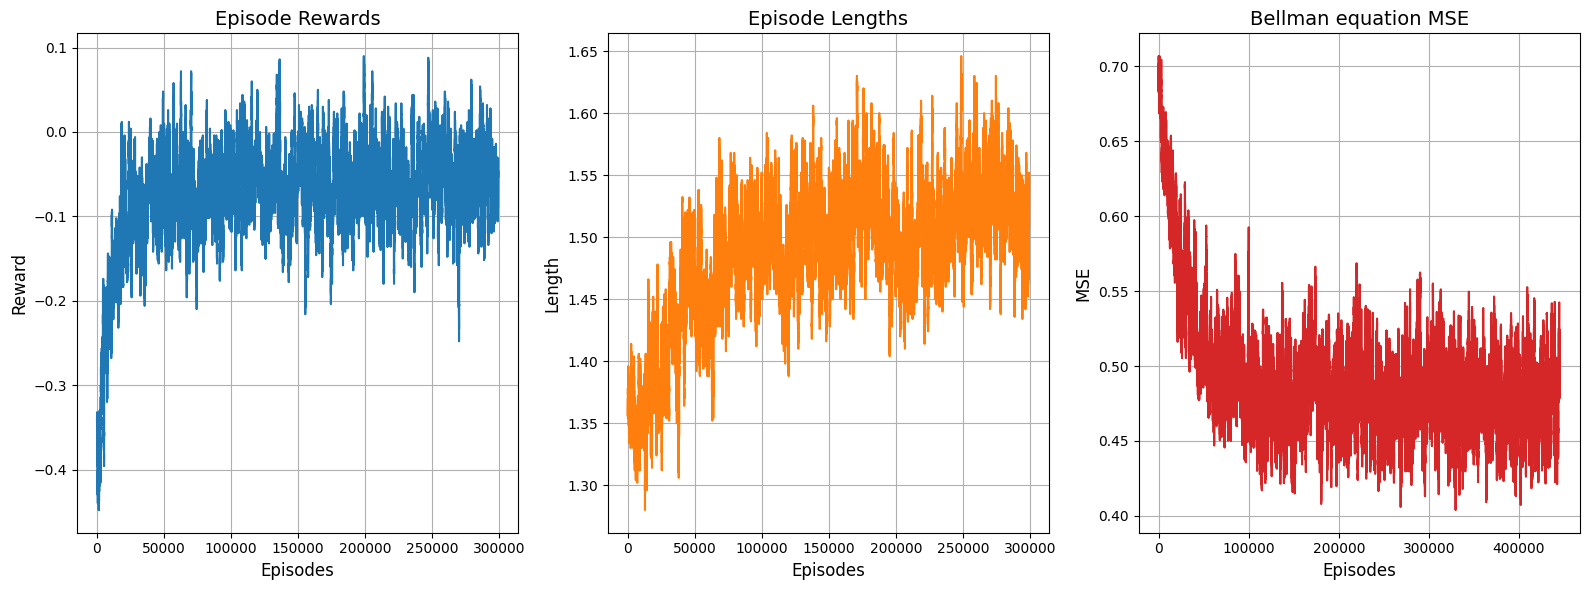

100%|██████████| 300000/300000 [14:59<00:00, 333.44it/s]


<RecordEpisodeStatistics<OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>>

In [8]:
n_episodes = 300_000
learning_rate = 4e-3
n_actions = env.action_space.n
epsilon = 1.0

env = gym.make("Blackjack-v1", sab=True)
sarsa_agent = SarsaAgent(
    n_actions=env.action_space.n,
    learning_rate=learning_rate,
    epsilon=epsilon,
    decay_factor=0.9,
)
train_agent(sarsa_agent, env, n_episodes, epsilon_decay=0.9)

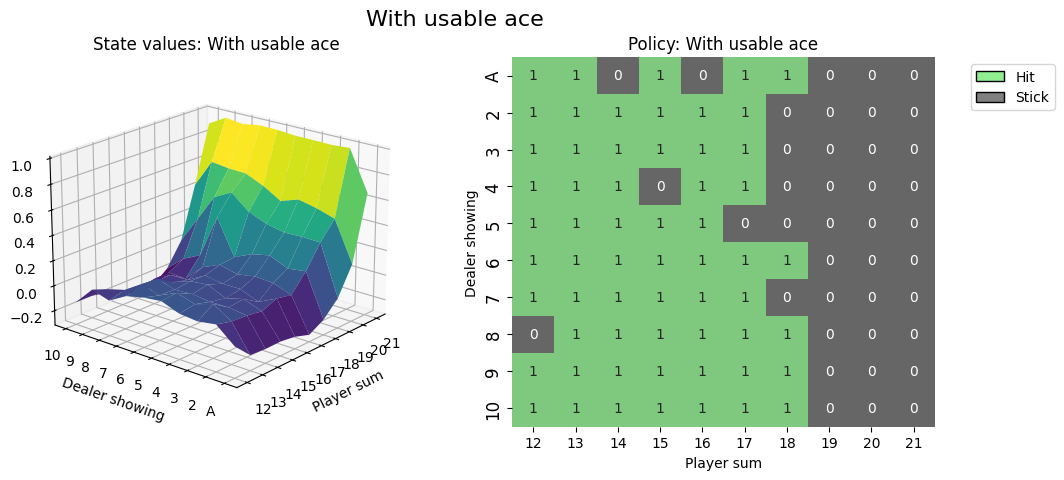

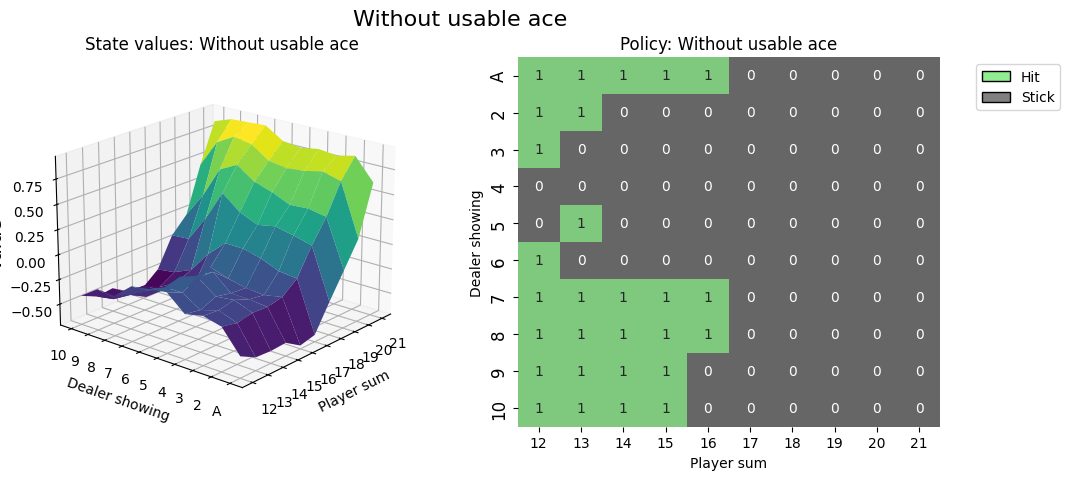

In [10]:
from visualisation_utils import visualise_strategy
visualise_strategy(sarsa_agent)

## Implement Expected Value Sarsa($\lambda$) 



In [11]:
class EVSarsaAgent(SarsaAgent):
    def get_value(self, state: StateType):
        value = (1 - self.epsilon) * max(self.q_values[state]) + self.epsilon * (np.mean(self.q_values[state]))
        return value

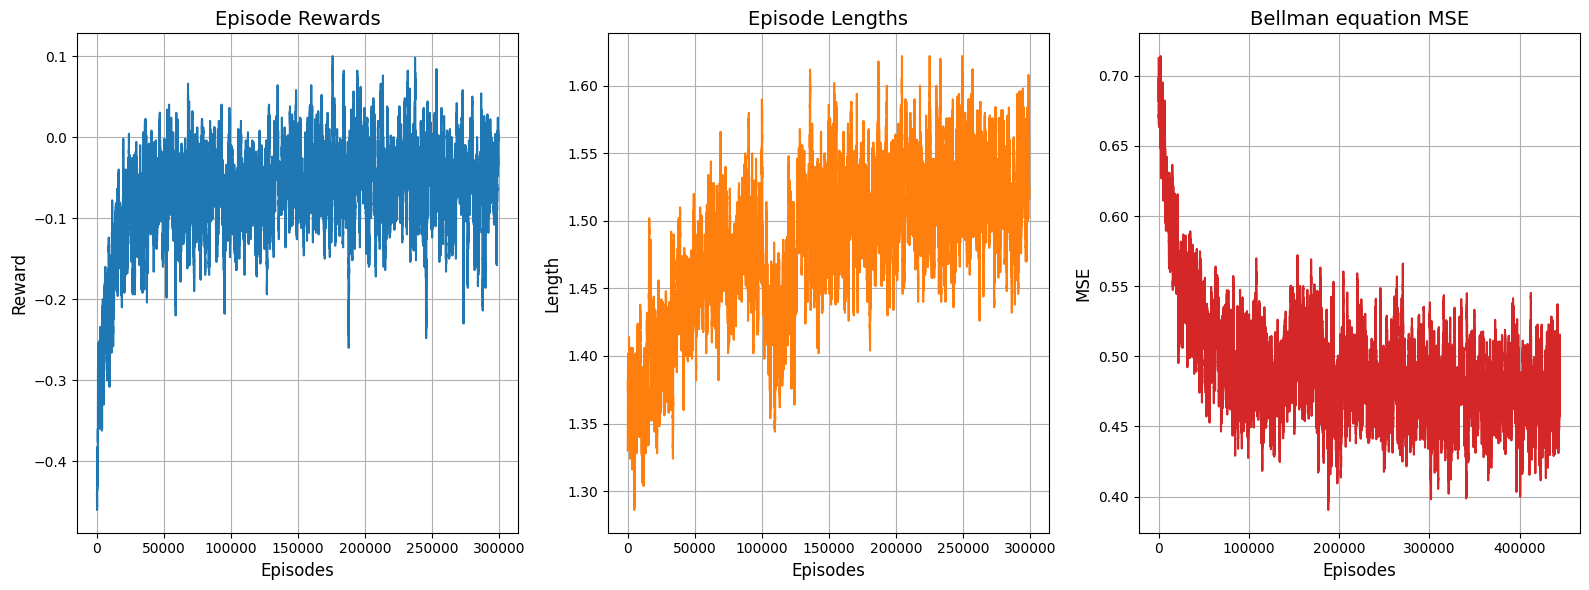

100%|██████████| 300000/300000 [14:26<00:00, 346.06it/s]


<RecordEpisodeStatistics<OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>>

In [12]:
env = gym.make("Blackjack-v1", sab=True)
expected_sarsa_agent = EVSarsaAgent(
    n_actions=env.action_space.n,
    learning_rate=learning_rate,
    epsilon=epsilon,
    decay_factor=0.9,
)

train_agent(expected_sarsa_agent, env, n_episodes, epsilon_decay=0.9)

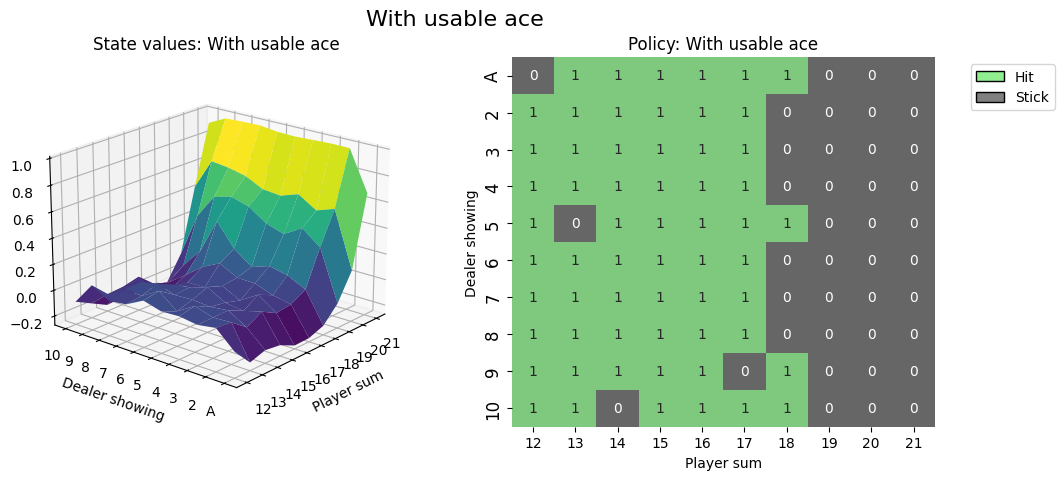

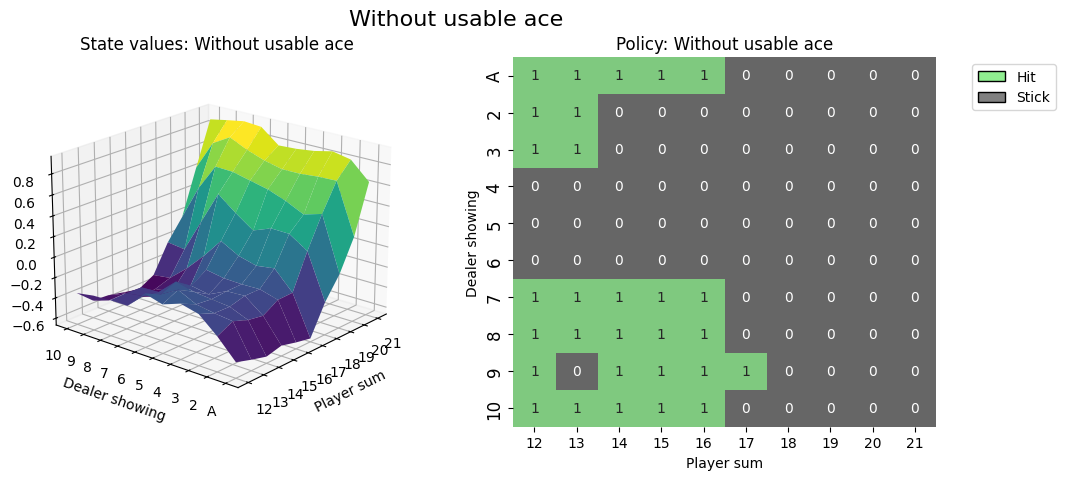

In [13]:
from visualisation_utils import visualise_strategy
visualise_strategy(expected_sarsa_agent)

### Evaluate agents


In [15]:
print(f'expected_sarsa_agent : {evaluate_agent(env, expected_sarsa_agent)}')
print(f'sarsa_agent {evaluate_agent(env, sarsa_agent)}')
print(f'q_learning_agent {evaluate_agent(env, q_learning_agent)}')

expected_sarsa_agent : {'win': 0.439, 'draw': 0.071, 'lose': 0.49}
sarsa_agent {'win': 0.418, 'draw': 0.087, 'lose': 0.495}
q_learning_agent {'win': 0.428, 'draw': 0.088, 'lose': 0.484}
